# Analysis of research papers' authors data

Data that will be analyzed is from Hugo Steinhaus Center website and refers to research paper written by its members.

In [194]:
import itertools
import requests
import re
import pprint
import warnings
import pandas as pd
from unidecode import unidecode
from bs4 import BeautifulSoup
from collections import Counter
from pylab import rcParams
from matplotlib.cm import ScalarMappable
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

# Downloading the data

Data was downloaded using requests library and saved into a .txt file.

In [168]:
def download_and_save_data():
    URL = "http://prac.im.pwr.wroc.pl/~hugo/HSC/Publications.html"
    headers = {'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36"}
    session = requests.Session()
    cont = session.get(URL, headers=headers)
    with open('data.txt', 'w') as f:
        f.write(str(cont.content.decode('utf16')))

In [169]:
with open('data.txt', 'r') as f:
    html_content = f.read()

soup = BeautifulSoup(html_content, "html.parser")

To get authors of research papers we iterate over all yearly content on the website and select the data that describes research papers. To handle html BeautifulSoup library is used.

After taking a look a the website we noticed some errors - some people are members of HSC but sometimes are not written in bold. We written out function in such way to escape such mistakes.

In [170]:
def get_authors_of_research():
    parts_per_year = [ol for ol in soup.find_all("ol")[2:-6]]
    parts_per_year.reverse()
    authors, in_bold = [], []
    for part in parts_per_year:
        whole_part = []
        for p in part.find_all("li"):
            whole_part += [a.get_text() for a in p.find_all("font") if all(['.' in a.get_text(), len(a.get_text().split(".")[0]) == 1])]
            pub = [a.get_text() for a in p.find_all("b")]
            in_bold += pub
            for auth in p.find_all("font"):
                if auth.get_text() in in_bold:
                    pub += [auth.get_text()]
            authors.append(list(set(pub)))

    return authors


To unify authors' names function clean_text is defined. It also takes into account problem with double surnames.

In [171]:
def clean_text(txt):
    txt = txt.replace(" ", "")
    txt = txt.capitalize()
    txt = unidecode(txt)
    return txt.split("-")[0] if "-" in txt else txt

After defining function for cleaning text we apply it to all authors in our data.

In [172]:
def clean_authors_txt(authors):
    cleaned = []
    for paper in authors:
        cleaned.append(clean_text(author) for author in paper)
    return cleaned

To get authors lists per publication another function is defined. It also handles research papers that were not written by HSC members.

In [173]:
def get_authors_lists():
    list_of_authors = []
    authors = get_authors_of_research()
    cleaned_authors = clean_authors_txt(authors)
    for aut in cleaned_authors:
        mini_list = []
        [mini_list.append(j) for j in aut]
        list_of_authors.append(mini_list)
    return list(filter(None, list_of_authors))

Then we want to get all combinations of collaborations between authors. To do so we define get_authors_pairs function.

In [174]:
def get_authors_pairs():
    authors_list = get_authors_lists()
    author_pairs = [i for i in authors_list if len(i) == 2]
    authors_above_2 = [j for j in authors_list if len(j) > 2]
    pairs = []
    for group in authors_above_2:
        combinations = list(itertools.combinations(group, 2))
        for pair in combinations:
            pairs.append(list(pair))
    author1 = get_authors_once()
    author_pairs = author_pairs + pairs
    return dict(Counter(tuple(sorted(tup)) for tup in author_pairs))

def get_authors_once():
    authors_list = get_authors_lists()
    return [i for i in authors_list if len(i)==1]


Then we want to get number of publications for every author.

In [175]:
def get_authors_size():
    authors_list = get_authors_lists()
    count = pd.Series(authors_list).explode().value_counts()
    return dict(count)

pprint.pprint(get_authors_size())

{'A.fulinski': 1,
 'A.grzesiek': 16,
 'A.janicki': 7,
 'A.jurlewicz': 36,
 'A.kumar': 4,
 'A.makagon': 2,
 'A.michalak': 12,
 'A.misiorek': 17,
 'A.stanislavsky': 9,
 'A.weron': 98,
 'A.wilkowska': 2,
 'A.wylomanska': 159,
 'B.kozlowska': 1,
 'B.przybylowicz': 1,
 'B.stawiarski': 1,
 'D.kucharczyk': 2,
 'D.szarek': 1,
 'E.broszkiewicz': 9,
 'G.krzyzanowski': 3,
 'G.kukla': 5,
 'G.sikora': 34,
 'G.zak': 10,
 'H.loch': 8,
 'J.gajda': 25,
 'J.goncerzewicz': 1,
 'J.gruszka': 2,
 'J.hebda': 5,
 'J.iwanik': 2,
 'J.janczura': 31,
 'J.nowicka': 23,
 'J.obuchowski': 20,
 'J.slezak': 8,
 'J.sokolowski': 1,
 'J.szwabinski': 11,
 'K.burnecki': 81,
 'K.maraj': 4,
 'L.bielak': 5,
 'L.plociniczak': 20,
 'M.balcerek': 10,
 'M.borgosz': 11,
 'M.kotulski': 7,
 'M.kozlowski': 4,
 'M.magdziarz': 69,
 'M.malek': 1,
 'M.muszkieta': 5,
 'M.teuerle': 22,
 'P.kowalek': 2,
 'P.kruczek': 12,
 'P.mista': 6,
 'P.sztuba': 2,
 'P.wilman': 1,
 'R.poloczanski': 6,
 'R.weron': 84,
 'S.ondruszko': 1,
 'S.orzel': 6,
 'S.

To examine how number of publications behaves every year we define functions below.

In [176]:
def get_no_of_papers_per_year():
    parts_per_year = [ol for ol in soup.find_all("ol")[2:-6]]
    parts_per_year.reverse()
    no_per_year = []
    for part in parts_per_year:
         no_per_year += [len(part.find_all("li"))]
    return no_per_year

def make_no_dict():
    no_per_year = get_no_of_papers_per_year()
    return {1995+i: no_per_year[i] for i in range(27)}

In [177]:
data = pd.DataFrame(make_no_dict().items(), columns=['year', 'count'])

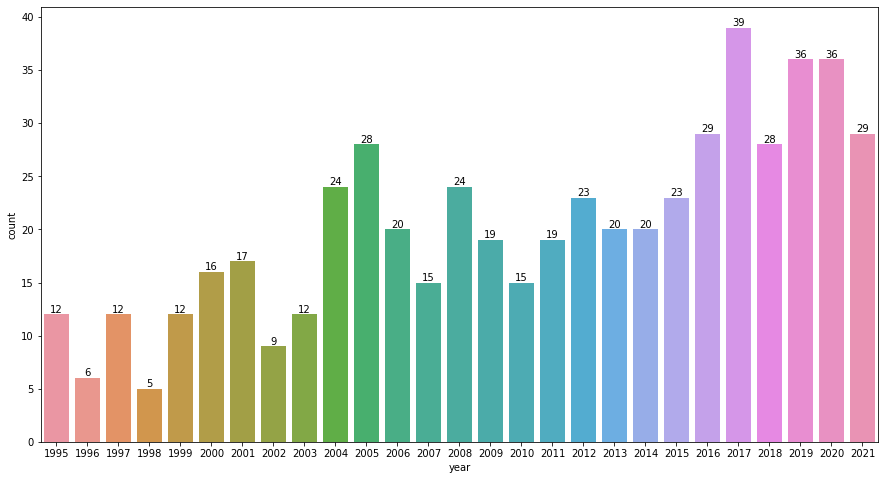

In [196]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,8))
chart = sns.barplot(data['year'], data['count'])
for p in chart.patches:
             chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
plt.show()

As we can see from above plot, there is a growing tendency in data. The most number of research papers were published in 2017 and the lowest was 1998.

# Network analysis

To plot graphs the networkx library will be used. To get such graphs for data we have to use functions defined before. 

In [179]:
authors_sizes = get_authors_size()
authors_dict = get_authors_pairs()

The graph object is defined. Nodes represent authors of papers and edges represent links between authors. Each link has a defined weight which correspond to number of cooperations between authors in nodes.

In [180]:
G = nx.Graph()
sizes = []
for n in authors_sizes.items():
    G.add_node(n[0])
    sizes.append(n[1]*4)

for k, v in authors_dict.items():
    G.add_edge(k[0], k[1], weight=v)

First we want to represent network on a simple graph using networkx package.

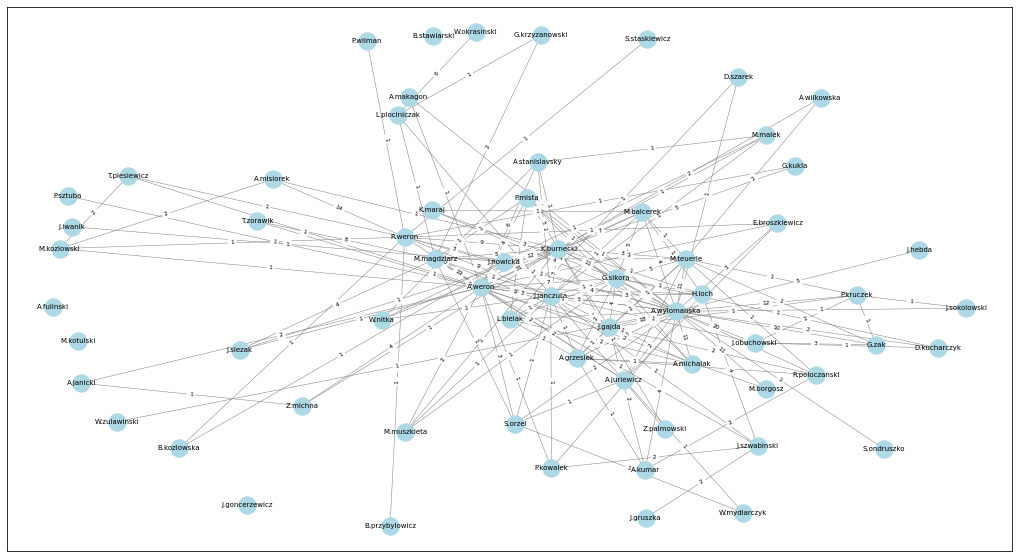

In [181]:
rcParams['figure.figsize'] = 18, 10
pos = nx.spring_layout(G, k=2, iterations=100, scale=2)
nx.draw_networkx(G, pos, with_labels=True, font_size=7,
                 node_color='lightblue', edge_color='grey', width=0.5)
labels = nx.get_edge_attributes(G, 'weight')
p = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=6,
                                 label_pos=0.5)

The graph is not easy to read. To help with that we will represent number of written papers by a person with its node size and we will skip labeling links.

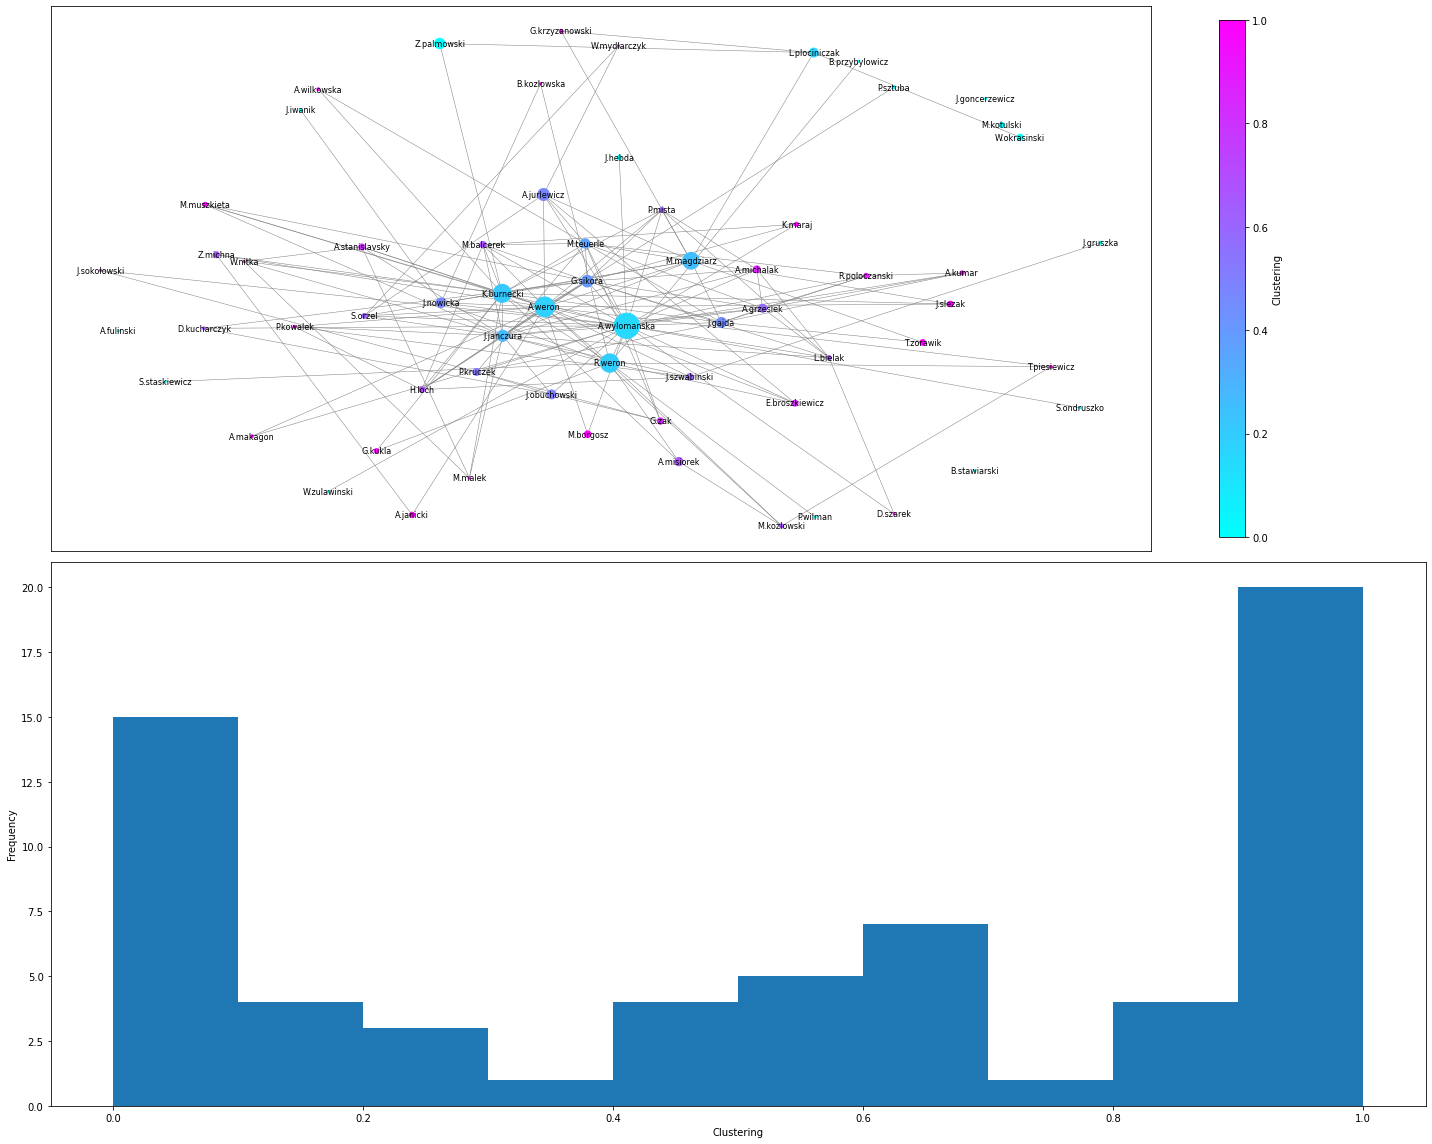

In [182]:
lcc = nx.clustering(G)
cmap = plt.get_cmap('cool')
norm = plt.Normalize(0, max(lcc.values()))
node_colors = [cmap(norm(lcc[node])) for node in G.nodes]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 16))
pos = nx.spring_layout(G, k=2, iterations=100, scale=2)
nx.draw_networkx(G, pos, with_labels=True, node_size=sizes, font_size=8,
                 node_color=node_colors, edge_color='grey', width=0.5, ax=ax1)

fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), label='Clustering', shrink=0.95, ax=ax1)

ax2.hist(lcc.values(), bins=10)
ax2.set_xlabel('Clustering')
ax2.set_ylabel('Frequency')
plt.tight_layout()

Size of each node is directly proportional to number of publications. Colors of nodes represent clustering coefficent. What is interesting is that in the middle of the graph we can see nodes with lower clustering and distancing further we can observe growing clustering coefficent and as we get to the end the nodes are back to light blue color which represent low clustering. We can also observe that some nodes don't have any links.

The changes in clustering coefficents can be explained by the facts that there are some authors, that write a lot of papers and cooperate with a lot of people but these people do not necessary cooperate with each other. Also we can observe second group that publishes slightly less papers but they are strongly connected and therefore have big clustering coefficents. And there is the last group that just does not publish that much and does not cooperate with a lot of people.

From histogram we can see that the most common value of clustering coefficent is 1, and second most popular is 0.

Next we will take a look at degree of nodes.

In [183]:
popular = G.degree
data_popular = pd.DataFrame(dict(popular).items(), columns=['name', 'count_of_research_papers'])
pprint.pprint([i for i in popular][:5])

[('A.wylomanska', 30),
 ('A.weron', 25),
 ('R.weron', 14),
 ('K.burnecki', 22),
 ('M.magdziarz', 12)]


The top five most popular researchers are Agnieszka Wyłomańska, Aleksander Weron, Rafał Weron, Krzysztof Burnecki and Marcin Dziekan Magdziarz.

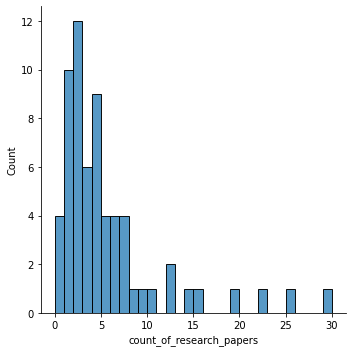

In [184]:
a = sns.displot(data_popular, x="count_of_research_papers", bins=30)

The most common number of research papers is 3 and 2.  

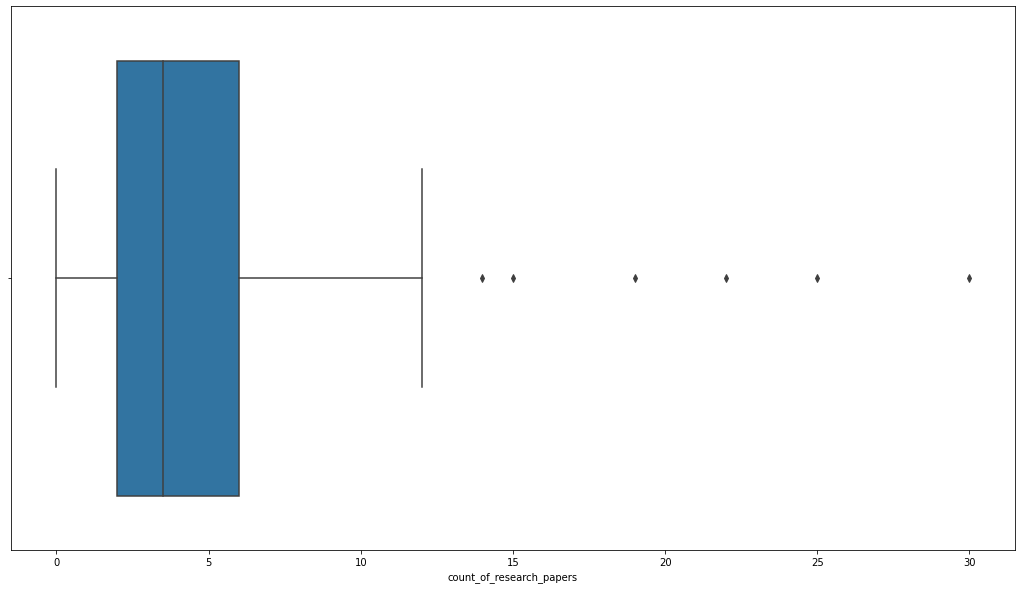

In [185]:
b = sns.boxplot(x=data_popular["count_of_research_papers"])

Median of quantity of written research papers is around 4. IQR is approximately 2-6. Values above 13 are considered outliers.

In [186]:
bridge = list(nx.bridges(G))
bridge

[('A.wylomanska', 'S.ondruszko'),
 ('A.wylomanska', 'J.hebda'),
 ('A.wylomanska', 'W.zulawinski'),
 ('A.weron', 'P.sztuba'),
 ('R.weron', 'B.przybylowicz'),
 ('R.weron', 'S.staskiewicz'),
 ('R.weron', 'P.wilman'),
 ('J.nowicka', 'J.iwanik'),
 ('L.plociniczak', 'W.okrasinski'),
 ('J.szwabinski', 'J.gruszka')]

There are 10 bridges in the network. We can see that Agnieszka Wyłomańska and Rafał Weron (which were one of the most popular) are the links which are considered bridges in the network.

In [187]:
avg_conn = nx.average_node_connectivity(G)
avg_conn

2.148313492063492

From average node connectivity we can say that it takes 2.15 paths on average to internally disjoint paths connecting vertices.

In [188]:
isolates = list(nx.isolates(G))
isolates

['M.kotulski', 'J.goncerzewicz', 'B.stawiarski', 'A.fulinski']

As seen on the graph there are some nodes that did not collaborate with anybody from HSC. To identify them we use isolates function from networkx package. There are exactly four such authors.

In [189]:
closeness = nx.closeness_centrality(G)
c = {k: v for k, v in sorted(closeness.items(), key=lambda item: item[1])}
c_data = pd.DataFrame(c.items(), columns=['name', 'closeness_centrality'])
c

{'M.kotulski': 0.0,
 'J.goncerzewicz': 0.0,
 'B.stawiarski': 0.0,
 'A.fulinski': 0.0,
 'W.okrasinski': 0.24023464458247068,
 'J.gruszka': 0.27765813192948874,
 'J.iwanik': 0.31216931216931215,
 'W.mydlarczyk': 0.31216931216931215,
 'G.krzyzanowski': 0.3175515416894727,
 'L.plociniczak': 0.3212440014765596,
 'B.przybylowicz': 0.3269465577157885,
 'S.staskiewicz': 0.3269465577157885,
 'P.wilman': 0.3269465577157885,
 'B.kozlowska': 0.33086208535310335,
 'T.zorawik': 0.3389814003310936,
 'Z.palmowski': 0.36351294903926484,
 'P.sztuba': 0.36351294903926484,
 'A.janicki': 0.36592031956270366,
 'J.hebda': 0.36592031956270366,
 'S.ondruszko': 0.36592031956270366,
 'W.zulawinski': 0.36592031956270366,
 'A.wilkowska': 0.36835978835978833,
 'J.sokolowski': 0.36835978835978833,
 'D.szarek': 0.36835978835978833,
 'G.kukla': 0.37083200170448494,
 'A.misiorek': 0.3733376233376233,
 'K.maraj': 0.3758773350610085,
 'D.kucharczyk': 0.3758773350610085,
 'W.nitka': 0.38106185002736725,
 'M.malek': 0.3810

The more central a node is, the closer it is to all other nodes. The nodes with highest closeness centrality is again the most popular one Agnieszka Wyłomańska. Next are Aleksander Weron, Krzysztof Burnecki and Joanna Janczura. The four authors have closeness centrality equal to zero - they are the authors that did not collaborate with anybody within the network.

In [190]:
np.mean([i for i in closeness.values()])

0.37466391648963293

Average closeness centrality for nodes in the graph is 0.37.

Text(0.5, 1.0, 'Closeness centrality')

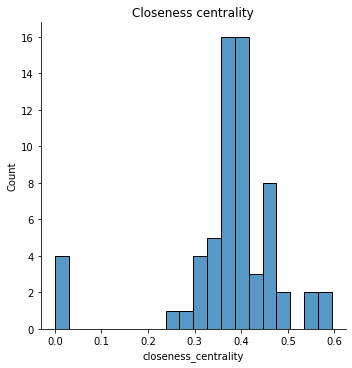

In [191]:
s = sns.displot(c_data, x="closeness_centrality")
plt.title("Closeness centrality")

The most values are around average. We can also observe an increase in count for value 0.0 which is for mentioned earlier lonely nodes.

In [192]:
data_popular = data_popular.set_index("name")
c_data = c_data.set_index("name")

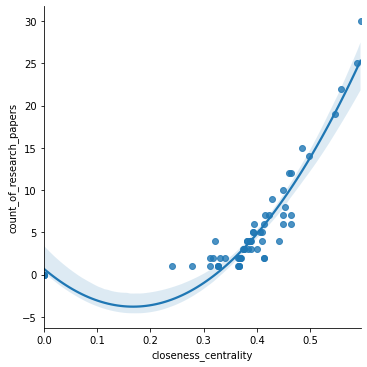

In [193]:
cor_data = pd.concat([data_popular, c_data], axis=1)
p = sns.lmplot(x='closeness_centrality', y='count_of_research_papers', data=cor_data, order=2) 

We can observe directly proportional relation between closeness centrality values and count of research papers.

# Summary

1. We can observe the nature of collaborations between members of HSC.
2. There are researches that can be really popular but do not have high clustering coefficent - which says that although they collaborate with a lot of different authors they do not necessarily collaborate with each other. It might be due to that they might be from different fields of science.
3. There are some authors that do not collaborate with any other HSC members.
4. Some nodes are popular, with low clustering and also are present in a lot of bridge links. It also might point to that they may be mediating a lot of fields of science.
5. We can observe growing trend in number of research papers that are published every year.